# Viasat Packet Analysis Feature Engineering

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import numpy as np
from scipy import stats

Roughly 20 minutes of both browsing and streaming data.

In [2]:
dfstr = pd.read_csv('pgaddiso-novideo-vpn-linux-20201109-0.csv')
dfbro = pd.read_csv('pgaddiso-youtube-1x-720p-novpn-linux-clean-20201102-0.csv')

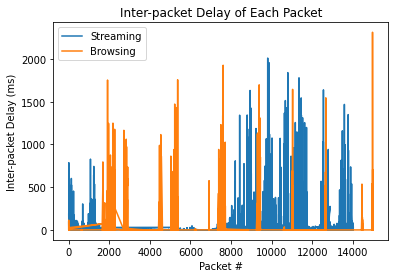

In [115]:
plt.plot(str_unpack.index[:15000],str_unpack['interpacket_delay'][:15000], label='Streaming')
plt.plot(bro_unpack.index[:15000],bro_unpack['interpacket_delay'][:15000], label='Browsing')
plt.xlabel('Packet #')
plt.legend()
plt.ylabel('Inter-packet Delay (ms)')
plt.title('Inter-Packet Delay of Each Packet');

## Feature 1: Interpacket Time Gap per Flow

Here, we look at the amount of time between each packet sent or received in a flow. Then, we average all the time gaps to create a column called 'avg_time_gaps'.

This is done by applying a diff function to each row in the aggregated flow data after parsing each of the packet arrival times. This includes both packets sent and received (direction 1 and 2).

In [3]:
def packet_time_gaps_per_sec(row):
    times = row['packet_times']
    times = times[:-1].split(';')
    times = [eval(i) for i in times]
    if len(times) == 1:
        return 0
    diffs = np.diff(times)
    return np.mean(diffs)
dfstr['avg_time_gaps'] = dfstr.apply(packet_time_gaps_per_sec, axis=1)
dfbro['avg_time_gaps'] = dfbro.apply(packet_time_gaps_per_sec, axis=1)

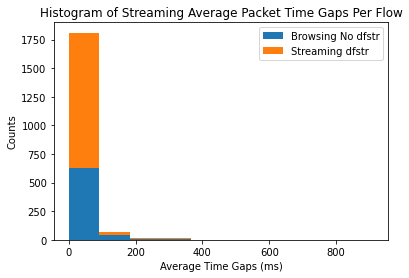

In [4]:
plt.hist([dfstr['avg_time_gaps'],dfbro['avg_time_gaps']],histtype='bar', stacked=True, label=['Browsing No dfstr','Streaming dfstr'])
plt.xlabel('Average Time Gaps (ms)')
plt.title('Histogram of Streaming Average Packet Time Gaps Per Flow')
plt.legend()
plt.ylabel('Counts');

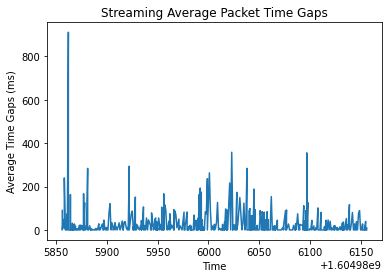

In [5]:
plt.plot(dfstr['Time'], dfstr['avg_time_gaps'])
plt.ylabel('Average Time Gaps (ms)')
plt.title('Streaming Average Packet Time Gaps')
plt.xlabel('Time');

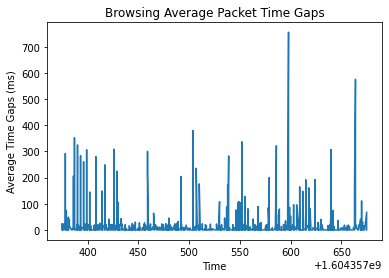

In [6]:
plt.plot(dfbro['Time'], dfbro['avg_time_gaps'])
plt.ylabel('Average Time Gaps (ms)')
plt.title('Browsing Average Packet Time Gaps')
plt.xlabel('Time');

Next, after visualizing the histogram distribution of time gaps for VPN and no VPN, as well as looking at a time series analysis of these gaps, I wanted to dig deeper into the counts and ratios of large and small time gaps. From these charts, I can tell that VPN data has more larger time gaps (above 600ms as a threshold).

In [7]:
#Counts of gaps below 200ms or above 600ms
dfstr_above_600 = len(dfstr[dfstr['avg_time_gaps']>600])
print('Streaming Above 600ms: %s'%(dfstr_above_600))
dfstr_below_200 = len(dfstr[dfstr['avg_time_gaps']<200])
print('Streaming Below 200ms: %s'%(dfstr_below_200))
dfbro_above_600 = len(dfbro[dfbro['avg_time_gaps']>600])
print('Browsing Above 600ms: %s'%(dfbro_above_600))
dfbro_below_200 = len(dfbro[dfbro['avg_time_gaps']<200])
print('Browsing Below 200ms: %s'%(dfbro_below_200))


Streaming Above 600ms: 1
Streaming Below 200ms: 672
Browsing Above 600ms: 1
Browsing Below 200ms: 1209


Although the results were not immediately visible from the charts above, counting the number of large and small time gaps provides more clarity. VPN data has 59 600ms+ time gaps while no VPN data only has 36. They have similar amounts of small time gaps. This might be a useful feature that will be based on the assumption that VPN data will ahve larger time gaps.

In [8]:
print('Streaming Time Gap Median: %s' % (dfstr['avg_time_gaps'].median()))
stats.describe(dfstr['avg_time_gaps'])

Streaming Time Gap Median: 0.0


DescribeResult(nobs=682, minmax=(0.0, 911.0), mean=21.673187798344028, variance=3245.731437347563, skewness=7.406957062421014, kurtosis=92.20363252369096)

In [9]:
print('Browsing Time Gap Median: %s' % (dfbro['avg_time_gaps'].median()))
stats.describe(dfbro['avg_time_gaps'])

Browsing Time Gap Median: 0.0


DescribeResult(nobs=1237, minmax=(0.0, 756.0), mean=16.47464901944362, variance=2793.9530859306637, skewness=6.293798691997658, kurtosis=54.21265674064991)

I also believe the mean, median, standard deviation, and variance can be useful features. Here we can see that Streaming data has a median time gap of 0ms while Browsing has a median time gap of 7ms. I would have expected some difference in the max time gap between the two datasets, but none are shown as of now. Also, although their means are similar, the Streaming data has larger variance and therefore a larger standard deviation that the no Streaming data. This can be a useful feature where while we cannot see definite results, the final model will hopefully calculate its significance.

### Feature 1a: Interpacket Time Gap per Packet

Next, we unpack flow level data into packet level data and applying the same interpacket delay analysis.

In [10]:
def unpack(s):
    s_unpacked = s[:-1].split(';')
    s_unpacked = [eval(i) for i in s_unpacked]
    return s_unpacked

def packet_data(row):
    unpacked_data = []
    times = unpack(row['packet_times'])
    sizes = unpack(row['packet_sizes'])
    dirs = unpack(row['packet_dirs'])
    entry = [list(a) for a in zip(times,sizes,dirs)]
    return entry

In [45]:
str_unpack = dfstr.apply(packet_data, axis=1)
str_unpack = pd.DataFrame(str_unpack.sum(), columns = ['time','size','direction'])
str_unpack = str_unpack.sort_values('time')

In [46]:
bro_unpack = dfbro.apply(packet_data, axis=1)
bro_unpack = pd.DataFrame(bro_unpack.sum(), columns = ['time','size','direction'])
bro_unpack = bro_unpack.sort_values('time')

In [47]:
str_unpack['interpacket_delay'] = str_unpack['time'].diff()
str_unpack = str_unpack.dropna()
print('Streaming Time Gap Median: %s' % (str_unpack['interpacket_delay'].median()))
stats.describe(str_unpack['interpacket_delay'])

Streaming Time Gap Median: 0.0


DescribeResult(nobs=14028, minmax=(0.0, 2010.0), mean=21.415383518676933, variance=11382.432634222332, skewness=9.235436140307948, kurtosis=106.97529659046677)

In [48]:
bro_unpack['interpacket_delay'] = bro_unpack['time'].diff()
bro_unpack = bro_unpack.dropna()
print('Browsing Time Gap Median: %s' % (bro_unpack['interpacket_delay'].median()))
stats.describe(bro_unpack['interpacket_delay'])

Browsing Time Gap Median: 0.0


DescribeResult(nobs=28169, minmax=(0.0, 2459.0), mean=10.668926834463416, variance=7034.568390075909, skewness=13.404912338718347, kurtosis=236.26552781064063)

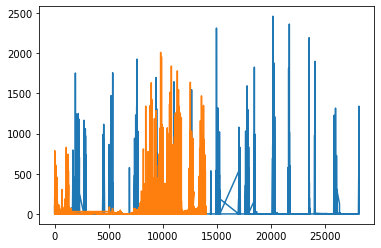

In [87]:
#plt.plot(bro_unpack['time'], bro_unpack['interpacket_delay'])
#plt.plot(str_unpack['time'], str_unpack['interpacket_delay'])
fig, ax = plt.subplots()
ax.plot(bro_unpack.index, bro_unpack['interpacket_delay'])
ax.plot(str_unpack.index, str_unpack['interpacket_delay'])

Here, we see drastically different results. The mean of packet level time gaps for Browsing data (14.99) is almost double that of Streaming data (7.66). Browsing data has a larger maximum interpacket delay and a much larger variance and standard deviation. Although these results differ than flow level data, it can also be a useful feature for the model.

## Feature 2: Counts and Ratios of Special Packets

In [49]:
#number of packets from 1-2 or 2-1
print('Streaming Number of Packets 1->2: %s' % len(str_unpack[str_unpack['direction']==1]))
print('Streaming Number of Packets 2->1: %s' % len(str_unpack[str_unpack['direction']==2]))
print('Browsing Number of Packets 1->2: %s' % len(bro_unpack[bro_unpack['direction']==1]))
print('Browsing Number of Packets 2->1: %s' % len(bro_unpack[bro_unpack['direction']==2]))

Streaming Number of Packets 1->2: 6948
Streaming Number of Packets 2->1: 7080
Browsing Number of Packets 1->2: 5770
Browsing Number of Packets 2->1: 22399


In [50]:
#ratios of 1->2/2->1 packets
print('Streaming source/dest packet ratio: %s' % (len(str_unpack[str_unpack['direction']==1])/len(str_unpack[str_unpack['direction']==2])))
print('Browsing source/dest packet ratio: %s' % (len(bro_unpack[bro_unpack['direction']==1])/len(bro_unpack[bro_unpack['direction']==2])))

Streaming source/dest packet ratio: 0.9813559322033898
Browsing source/dest packet ratio: 0.2576007857493638


I also wanted to take a look at the count and ratio of packets being sent vs received. We can see that in the str data, we receive many more packets compared to no str data (220065 vs 46302). And the ratio of packets sent over packets received for no str data is almost double of that of str data (0.79 vs 0.40).

In [51]:
#Histogram of packet sizes vs direction
def hist_data(df):
    sizes = df['packet_sizes'].values
    dirs = df['packet_dirs'].values
    dir_12 = []
    dir_21 = []
    for i in range(len(sizes)):
        sizes_lst, dirs_lst = sizes[i][:-1].split(';'), dirs[i][:-1].split(';')
        size_dir = list(zip(sizes_lst, dirs_lst))
        #print(size_dir)
        for tup in size_dir:
            if tup[1] == '1':
                dir_12.append(tup[0])
            else:
                dir_21.append(tup[0])
    dir_12 = [eval(i) for i in dir_12]
    dir_21 = [eval(i) for i in dir_21]
    return dir_12, dir_21
str_dir_12, str_dir_21 = hist_data(dfstr)
bro_dir_12, bro_dir_21 = hist_data(dfbro)

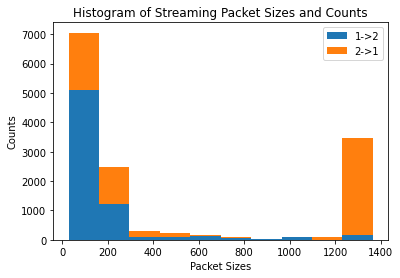

In [52]:
plt.hist([str_dir_12, str_dir_21],histtype='bar', stacked=True, label=['1->2','2->1'])
plt.xlabel('Packet Sizes')
plt.title('Histogram of Streaming Packet Sizes and Counts')
plt.legend()
plt.ylabel('Counts');

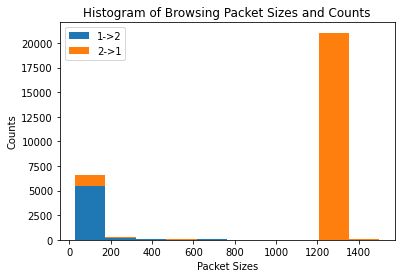

In [53]:
plt.hist([bro_dir_12, bro_dir_21],histtype='bar', stacked=True, label=['1->2','2->1'])
plt.xlabel('Packet Sizes')
plt.title('Histogram of Browsing Packet Sizes and Counts')
plt.legend()
plt.ylabel('Counts');

Looking at these distributions of packet sizes between Streaming and Browsing data, I hypothesized that Streaming data would send more larger packets than Browsing data. To explore my hypothesis, I looked at the number of small (below 200 bytes) and large (above 1200 bytes) packets, as well as their counts for each direction.

In [54]:
#number of packets above 1200, or below 200
print('Streaming Number of Packets above 1200: %s' % len(str_unpack[str_unpack['size']>1200]))
print('Streaming Number of Packets below 200: %s' % len(str_unpack[str_unpack['size']<200]))
print('Browsing Number of Packets above 1200: %s' % len(bro_unpack[bro_unpack['size']>1200]))
print('Browsing Number of Packets below 200: %s' % len(bro_unpack[bro_unpack['size']<200]))

Streaming Number of Packets above 1200: 3456
Streaming Number of Packets below 200: 8562
Browsing Number of Packets above 1200: 21087
Browsing Number of Packets below 200: 6684


In [55]:
#number of packets from 1-2 above 1200 or below 200
print('Streaming # Packets 1->2 Above 1200: %s' % len(str_unpack[(str_unpack['direction']==1) & (str_unpack['size']>1200)]))
print('Streaming # Packets 1->2 Below 200: %s' % len(str_unpack[(str_unpack['direction']==1) & (str_unpack['size']<200)]))
print('Browsing # Packets 1->2 Above 1200: %s' % len(bro_unpack[(bro_unpack['direction']==1) & (bro_unpack['size']>1200)]))
print('Browsing # Packets 1->2 Below 200: %s' % len(bro_unpack[(bro_unpack['direction']==1) & (bro_unpack['size']<200)]))

Streaming # Packets 1->2 Above 1200: 176
Streaming # Packets 1->2 Below 200: 5767
Browsing # Packets 1->2 Above 1200: 35
Browsing # Packets 1->2 Below 200: 5503


In [56]:
#number of packets from 2-1 above 1200 or below 200
print('Streaming Packets 2->1 Above 1200: %s' % len(str_unpack[(str_unpack['direction']==2) & (str_unpack['size']>1200)]))
print('Streaming Packets 2->1 Below 200: %s' % len(str_unpack[(str_unpack['direction']==2) & (str_unpack['size']<200)]))
print('Browsing # Packets 2->1 Above 1200: %s' % len(bro_unpack[(bro_unpack['direction']==2) & (bro_unpack['size']>1200)]))
print('Browsing # Packets 2->1 Below 200: %s' % len(bro_unpack[(bro_unpack['direction']==2) & (bro_unpack['size']<200)]))

Streaming Packets 2->1 Above 1200: 3280
Streaming Packets 2->1 Below 200: 2795
Browsing # Packets 2->1 Above 1200: 21052
Browsing # Packets 2->1 Below 200: 1181


First, we can see that Streaming data inherently transfers more larger packets. Streaming data transferred 205913 packets above 1200 bytes while Browsing only transferred 34517 packets above 1200 bytes. More small packets might be ACK packets, which Streaming data also takes the lead in.

Next, from looking at packets being sent 1->2, we see that Browsing data actually transfers more large packets, but less smaller packets. And from direction 2->1, we see that is where Streaming data is transferring the bulk of its large packets, but is not transferring many small packets. Similarly, from 2->1 is also where Browsing data is transferring the bulk of its large packets as well.

We can even use this ratio of large and small packets in each direction compared to the entire packet count as another feature.

In [78]:
print('Streaming Ratio of Packets 2->1 Above 1200: %s' % (len(str_unpack[(str_unpack['direction']==2) & (str_unpack['size']<200)]) / len(str_unpack[str_unpack['size']<200])))

Streaming Ratio of Packets 2->1 Above 1200: 0.3264424199953282


In [80]:
print('Browsing Ratio of Packets 2->1 Above 1200: %s' % (len(bro_unpack[(bro_unpack['direction']==2) & (bro_unpack['size']<200)]) / len(bro_unpack[bro_unpack['size']<200]))) 

Browsing Ratio of Packets 2->1 Above 1200: 0.17669060442848594


In [72]:
print('Browsing Ratio of Packets 1->2 Above 1200: %s' % (len(bro_unpack[(bro_unpack['direction']==2) & (bro_unpack['size']>1200)]) / len(bro_unpack[bro_unpack['size']>1200]))) 

Browsing Ratio of Packets 1->2 Above 1200: 0.9983402096078152


Or we can look at the ratio of large packets compared to all packets in both streaming and browsing data.

In [59]:
print('Streaming Ratio of Packets Above 1200: %s' % (len(str_unpack[(str_unpack['size']>1200)]) / len(str_unpack)))

Streaming Ratio of Packets Above 1200: 0.24636441402908468


In [60]:
print('Browsing Ratio of Packets Above 1200: %s' % (len(bro_unpack[(bro_unpack['size']>1200)]) / len(bro_unpack)))

Browsing Ratio of Packets Above 1200: 0.7485888742944371


## Feature 3: Longest Streaks

As an experimental feature, I wanted to look at the longest running streak of packets being sent from 1->2 and 2->1 in both datasets.

In [61]:
#Streaming longest streak of direction 1 and 2 packets
def longest_dir_streak(vals, dir):
    longest = 0
    current = 0
    for num in vals:
        if num == dir:
            current += 1
        else:
            longest = max(longest, current)
            current = 0

    return max(longest, current)
print('Streaming Longest Streak of Direction 1 Packets: %s' % longest_dir_streak(str_unpack['direction'], 1))
print('Streaming Longest Streak of Direction 2 Packets: %s' % longest_dir_streak(str_unpack['direction'], 2))

Streaming Longest Streak of Direction 1 Packets: 23
Streaming Longest Streak of Direction 2 Packets: 29


In [62]:
#No VPN longest streak of direction 1 and 2 packets
print('Browsing Longest Streak of Direction 1 Packets: %s' % longest_dir_streak(bro_unpack['direction'], 1))
print('Browsing Longest Streak of Direction 2 Packets: %s' % longest_dir_streak(bro_unpack['direction'], 2))

Browsing Longest Streak of Direction 1 Packets: 17
Browsing Longest Streak of Direction 2 Packets: 120


Here, we can see that streaming data has longer streaks in direction 1 and 2 packets. Not quite sure what to make of this yet, but keeping as a feature. The longer streaks could be due to more consistent data of the same content, which is they need more packets sent more closely together to package the data together?

### Downtime

Here, I'm looking at the longest streak of small packets, or in other words, downtime, which is when the network isn't experiencing any large packet transfers. So, I'm looking at how long it takes (in milliseconds) it takes in the longest gap of no packet above 1200 bytes.

In [94]:
str_unpack[(str_unpack['size'] > 1200)]['time'].diff().sort_values() 

4652         0.0
4572         0.0
4573         0.0
4582         0.0
4583         0.0
          ...   
9154     23139.0
10234    25810.0
10868    29295.0
11658    33294.0
28           NaN
Name: time, Length: 3456, dtype: float64

In [63]:
# VPN longest streak of no packet above 1200 from 2->1
str_longest_downtime = str_unpack[(str_unpack['direction']==2) & (str_unpack['size'] > 1200)]
str_longest_downtime = str_longest_downtime.sort_values('time')
print('Streaming longest streak of no packet above 1200 from 2->1: %s' % str_longest_downtime['time'].diff().max())

Streaming longest streak of no packet above 1200 from 2->1: 105824.0


In [64]:
# No VPN longest streak of no packet above 1200 from 2->1
bro_longest_downtime = bro_unpack[(bro_unpack['direction']==2) & (bro_unpack['size'] > 1200)]
bro_longest_downtime = bro_longest_downtime.sort_values('time')
print('Browsing longest streak of no packet above 1200 from 2->1: %s' % bro_longest_downtime['time'].diff().max())

Browsing longest streak of no packet above 1200 from 2->1: 33174.0


In [95]:
bro_unpack[(bro_unpack['size'] > 1200)]['time'].diff().sort_values() 

13918        0.0
18993        0.0
18994        0.0
18995        0.0
18998        0.0
          ...   
17851    19005.0
20365    19193.0
21764    20031.0
7730     33156.0
28           NaN
Name: time, Length: 21087, dtype: float64

My hypothesis was that general browsing would have longer downtime since video streaming is always transmitting data, but the time gaps I got were inconclusive for these datasets at least. It could be a useful feature in the future for other datasets.